# Solver benchmarks and problem examples

This notebook contains several examples of famous optimization problems. Randomly-initialized problem instances are generated using corresponding factories and used to benchmark solvers. Wall runtime of several solvers is compared for different sizes of problem instances. Runtime variability analysis is also shown.

* Linear program with number of constraints equal to number of decision variables.
* Knapsack problem
* Assignment problem


In [1]:
import time
import random
import pyomo.environ as pyo
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

#%matplotlib qt
%matplotlib inline

In [32]:
def lp_factory(num_vars, seed=42):
    """Function to generate a random linear programming model.

    Args:
        num_vars (_type_): number of variables and constraints

    Returns:
        _type_: _description_
    """

# Set random seed if provided
    if seed is not None:
        random.seed(seed)

    # Initialize the model
    model = pyo.ConcreteModel()

    # Define decision variables
    model.vars = pyo.Var(range(num_vars), domain=pyo.NonNegativeReals)

    # Randomly generate the objective function coefficients
    obj_coeffs = [random.uniform(1, 10) for _ in range(num_vars)]
    model.objective = pyo.Objective(
        expr=sum(obj_coeffs[i] * model.vars[i] for i in range(num_vars)), sense=pyo.maximize  # Maximization
    )

    # Randomly generate constraints
    model.constraints = pyo.ConstraintList()
    for _ in range(num_vars):
        coeffs = [random.uniform(0, 10) for _ in range(num_vars)]
        rhs = random.uniform(10, 100)  # Random RHS value
        # Add the constraint as a relational expression
        model.constraints.add(expr=sum(coeffs[i] * model.vars[i] for i in range(num_vars)) <= rhs)
    return model


In [33]:
def knapsack_factory(num_objects, seed=42):
    """
    Function to generate a random knapsack problem.
    """
    # Set random seed if provided
    if seed is not None:
        random.seed(seed)
        
    # Initialize the model
    model = pyo.ConcreteModel()

    # Define variables: x[i] is 1 if object i is included in the knapsack, else 0
    model.x = pyo.Var(range(num_objects), domain=pyo.Binary)

    # Randomly generate weights and costs
    weights = [random.uniform(1, 10) for _ in range(num_objects)]
    costs = [random.uniform(1, 20) for _ in range(num_objects)]

    # Define the knapsack capacity as half of the sum of all weights
    capacity = sum(weights) / 2

    # Objective: Maximize the total cost of objects included in the knapsack
    model.objective = pyo.Objective(
        expr=sum(costs[i] * model.x[i] for i in range(num_objects)),
        sense=pyo.maximize
    )

    # Constraint: Total weight of objects included in the knapsack should not exceed the capacity
    model.weight_constraint = pyo.Constraint(
        expr=sum(weights[i] * model.x[i] for i in range(num_objects)) <= capacity
    )

    return model

In [34]:
def assignment_factory(num_categories, seed=None):
    """
    Randomly generated assignment problem.

    Number of labels = 2 * number of categories
    
    Parameters:
        solver_name (str): Name of the solver to use (e.g., 'cbc', 'highs', 'gurobi').
        num_categories (int): Number of categories.
        seed (int, optional): Random seed for reproducibility.
        
    Returns:
        dict: A dictionary containing benchmark results.
    """
    # Set random seed if provided
    if seed is not None:
        random.seed(seed)

    # Number of labels
    num_labels = num_categories*2
        
    # Initialize the model
    model = pyo.ConcreteModel()

    # Define variables: x[c, l] is 1 if category c is assigned to label l, else 0
    model.assignments = pyo.Var(
        range(num_categories), range(num_labels), domain=pyo.Binary
    )

    # Randomly generate assignment costs
    costs = {
        (c, l): random.uniform(1, 10)
        for c in range(num_categories)
        for l in range(num_labels)
    }

    # Objective: Minimize the total cost of assignment
    model.objective = pyo.Objective(
        expr=sum(
            costs[c, l] * model.assignments[c, l]
            for c in range(num_categories)
            for l in range(num_labels)
        ),
        sense=-1 # maximizing
    )

    # Constraints: Each category is assigned at most one label
    model.category_constraints = pyo.Constraint(
        range(num_categories),
        rule=lambda model, c: sum(model.assignments[c, l] for l in range(num_labels)) <= 1,
    )

    # Constraints: A label can be assigned to at most one category
    model.label_constraints = pyo.Constraint(
        range(num_labels),
        rule=lambda model, l: sum(model.assignments[c, l] for c in range(num_categories)) <= 1,
    )

    return model

In [35]:
def benchmark_model(model, solver_name, num_vars, seed=42):

    # Solve the problem and measure the time
    solver = pyo.SolverFactory(solver_name)
    start_time = time.time()
    result = solver.solve(model)
    end_time = time.time()

    # Check optimality
    optimality_reached = (
        result.solver.termination_condition.lower() == 'optimal'
    )

    # Return benchmark results
    return {
        "solver": solver_name,
        "num_vars": num_vars,
        "time_taken": end_time - start_time,
        "optimality_reached": optimality_reached,
        "random_seed": seed,
    }


In [36]:
def benchmark_scaling(solver_names, factory, num_vars_list, seed=42):

    # Initialize the results list
    results = []

    # Iterate over the solvers
    for solver_name in solver_names:
        # Iterate over the number of variables
        for num_vars in num_vars_list:
            # Create the model
            model = factory(num_vars, seed=seed)
            # Benchmark the model
            result = benchmark_model(model, solver_name, num_vars, seed=seed)
            # Append the results to the list
            results.append(result)
    
    # Visualize the results
    results_df = pd.DataFrame(results)
    fig, ax = plt.subplots(figsize=(6, 4))
    for solver_name, group in results_df.groupby("solver"):
        group.plot(x="num_vars", y="time_taken", ax=ax, label=solver_name, marker="d", linestyle="--", alpha=1, ms=5)
    ax.legend()
    plt.show()

    # Return the results as a DataFrame
    return results_df

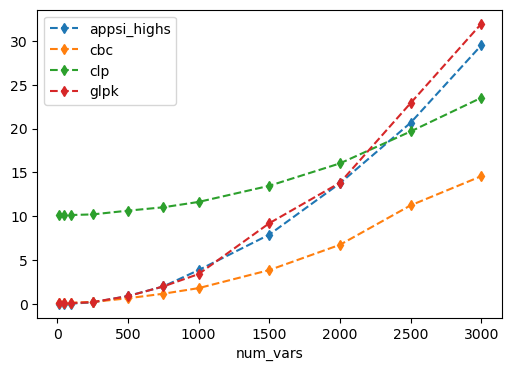

,solver,num_vars,time_taken,optimality_reached,random_seed
0,glpk,10,0.046703,True,42
1,glpk,50,0.052340,True,42
2,glpk,100,0.076252,True,42
3,glpk,250,0.198709,True,42
4,glpk,500,0.872773,True,42
5,glpk,750,1.983752,True,42
6,glpk,1000,3.398999,True,42
7,glpk,1500,9.204798,True,42
8,glpk,2000,13.827437,True,42
9,glpk,2500,22.930713,True,42


In [45]:
lp_benchmark_df = benchmark_scaling(['glpk', 'clp', 'cbc', 'appsi_highs',], lp_factory, [10, 50, 100, 250, 500, 750, 1000, 1500, 2000, 2500, 3000], seed=42)
lp_benchmark_df

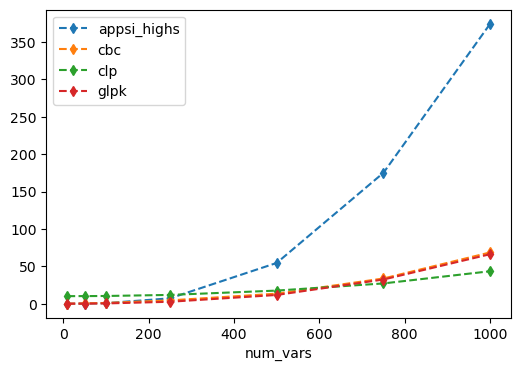

,solver,num_vars,time_taken,optimality_reached,random_seed
0,glpk,10,0.063169,True,42
1,glpk,50,0.159023,True,42
2,glpk,100,0.397032,True,42
3,glpk,250,2.636622,True,42
4,glpk,500,11.735932,True,42
5,glpk,750,32.403719,True,42
6,glpk,1000,66.294444,True,42
7,clp,10,10.149977,True,42
8,clp,50,10.218257,True,42
9,clp,100,10.361237,True,42


In [46]:
assignment_benchmark_df = benchmark_scaling(["glpk", 'clp', 'cbc', 'appsi_highs',], assignment_factory,
                                            [10, 50, 100, 250, 500, 750, 1000], seed=42)
assignment_benchmark_df

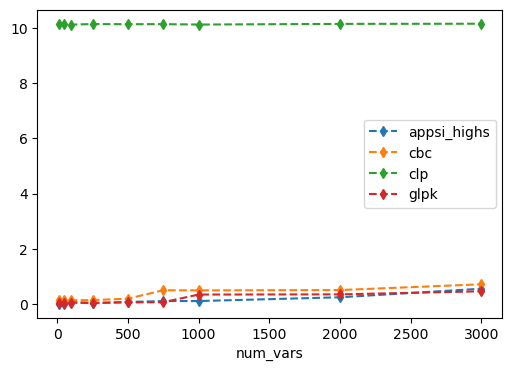

,solver,num_vars,time_taken,optimality_reached,random_seed
0,glpk,10,0.044725,True,42
1,glpk,50,0.046409,True,42
2,glpk,100,0.047658,True,42
3,glpk,250,0.044357,True,42
4,glpk,500,0.056829,True,42
5,glpk,750,0.063286,True,42
6,glpk,1000,0.340279,True,42
7,glpk,2000,0.347331,True,42
8,glpk,3000,0.458493,True,42
9,clp,10,10.129035,True,42


In [49]:
knapsack_benchmark_df = benchmark_scaling(["glpk", 'clp', 'cbc', 'appsi_highs',], knapsack_factory,
                                            [10, 50, 100, 250, 500, 750, 1000, 2000, 3000,], seed=42)
knapsack_benchmark_df

In [39]:
def benchmark_variation(solver_names, factory, num_vars, num_repetions=10):

    # Initialize the results list
    results = []

    # Iterate over the solvers
    for solver_name in solver_names:
        # Iterate over the number of variables
        for seed in range(num_repetions):
            # Create the model
            model = factory(num_vars, seed=seed)
            # Benchmark the model
            result = benchmark_model(model, solver_name, num_vars, seed=seed)
            # Append the results to the list
            results.append(result)
    
    # Visualize the results
    results_df = pd.DataFrame(results)
    fig, ax = plt.subplots(figsize=(6, 4))
    sns.stripplot(data=results_df, x="solver", y="time_taken", ax=ax)
    ax.set_title(f"Variation in Time Taken for Solving {num_vars}-Variable LP")
    plt.show()

    # Return the results as a DataFrame
    return results_df

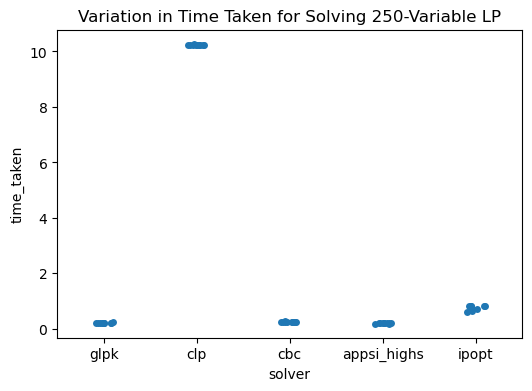

In [52]:
lp_reproducibility_df = benchmark_variation(["glpk", 'clp', 'cbc', 'appsi_highs', 'ipopt'], lp_factory, 250, num_repetions=10)

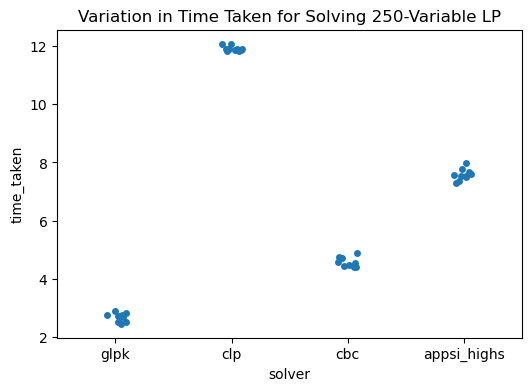

In [53]:
assignment_reproducibility_df = benchmark_variation(["glpk", 'clp', 'cbc', 'appsi_highs',], assignment_factory, 250, num_repetions=10)

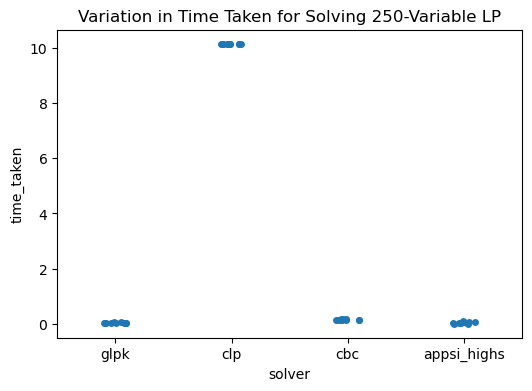

In [55]:
knapsack_reproducibility_df = benchmark_variation(["glpk", 'clp', 'cbc', 'appsi_highs',], knapsack_factory, 250, num_repetions=10)